<a href="https://colab.research.google.com/github/Daishinkan002/Sentiment-Analysis-of-Marathi-Tweets/blob/main/Dataset_Preprocessing_and_Traditional_ML_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
!python -m pip install tqdm pandas numpy seaborn matplotlib scikit-learn nltk

In [ ]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import string
from multiprocessing import Pool
import re
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Data Preprocessing and analyzing

In [ ]:
df_train=pd.read_csv("Dataset/tweets-train.csv",encoding="utf-8")
df_test=pd.read_csv("Dataset/tweets-test.csv",encoding="utf-8")
df_valid=pd.read_csv("Dataset/tweets-valid.csv",encoding="utf-8")

In [ ]:
df_train.head()

In [ ]:
df_train["label"].value_counts()

In [ ]:
df_test["label"].value_counts()

In [ ]:
df_valid["label"].value_counts()

In [ ]:
# extract stop and rare words
import string
import re
import operator
def extract_rare_stop(df):
  stop_words=[]
  rare_words=[]
  token_count = {}
  nc=0
  for line in df['tweet']:
    line = line.strip()
    line = re.split(r'\s+|[!$%&()*+, -./:;<=>?\^_`{|}~]\s*', line)
    line = [token.strip() for token in line if token != '' and token != ' ' and token != '\n']
    if len(line) > 1:
      for i in range(len(line)):
        if line[i].lower() in token_count:
          token_count[line[i].lower()] += 1
        else:
          token_count[line[i].lower()] = 1
      nc=nc+1

  token_count = dict(sorted(token_count.items(), key=operator.itemgetter(1)))
  for key, value in token_count.items():
    if value >= 100:
      stop_words.append(key.lower())
    elif value <2:
      rare_words.append(key.lower())
  return rare_words,stop_words

In [ ]:
rare_words, stop_words =  extract_rare_stop(df_train)

In [ ]:
print(len(rare_words),len(stop_words))

In [ ]:
rare_words[:10]

In [ ]:
stop_words[:10]

In [ ]:
# stop words rare words

## removal of stopwords & rarewords changes the meaning of it so to maintain the context we didn't do it

In [ ]:
# strip -> punctuations  -> @ mentions delete -> url delete ->  remove # from #-tokens -> stop words delete (no delete )  -> rare words no delete)
def preprocess(line):

  line = line.strip()
  line = re.sub(r'\S*\.com\S*'," ",line)
  line = re.sub(r'\S*\.in\S*'," ",line)
  line = re.sub(r'\S*\.net\S*'," ",line)
  line = re.sub(r'\S*\.me\S*'," ",line)
  line = re.sub(r'\s+:\s+'," ",line)
  line = re.sub(r'\s+-\s+'," ",line)
  
  
  line = re.sub(r'/https?\/\/(.*\.(in))\//'," ",line)
  line = re.split(r'\s+|[!$%&()*+./;<=>?\^`{|}~\'\"]\s*', line)
  line = [token.strip() for token in line if token != '' and token != ' ' and token != '\n']
  
  if len(line) > 1:
    tokens = []
    for i in range(len(line)):
      if line[i][0] == '#':
        tokens.append(line[i][1:])
      elif line[i][0] == '@' or line[i][0] in string.punctuation :
        continue
      else:
        tokens.append(line[i])
    return tokens


In [ ]:
preprocess("""  󾭴...अन्यथा ""सुपारीवाले' म्हणून पाहिले जाईल : खा. राजू शेट्टी
21 मे 2016 - सकाळ 
पुणे - '''शेतकऱ्यांची चळवळ ही... fb.me/1cIUGmX6V
""")

In [ ]:
with Pool(5) as pool:
 extracted = pool.map(preprocess, tqdm(df_train['tweet']))
 print(extracted[:5])

In [ ]:
df_train["tuned_tweet"] = extracted

In [ ]:
with Pool(5) as pool:
 extracted = pool.map(preprocess, tqdm(df_test['tweet']))
 print(extracted[:5])

In [ ]:
df_test["tuned_tweet"] = extracted

In [ ]:
with Pool(5) as pool:
 extracted = pool.map(preprocess, tqdm(df_valid['tweet']))
 print(extracted[:5])

In [ ]:
df_valid["tuned_tweet"] = extracted

In [ ]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)
df_valid.dropna(inplace=True)

In [ ]:
df_train['tuned_tweet'] = df_train['tuned_tweet'].apply(lambda x: " ".join(x))
df_test['tuned_tweet'] = df_test['tuned_tweet'].apply(lambda x: " ".join(x))
df_valid['tuned_tweet'] = df_valid['tuned_tweet'].apply(lambda x: " ".join(x))

In [ ]:
print(len(df_train),len(df_test),len(df_valid))

In [ ]:
print(df_train["label"].value_counts(),df_test["label"].value_counts(),df_valid["label"].value_counts())

# Dataset Loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
df_train = pd.read_pickle('/content/gdrive/MyDrive/Major_Project/Marathi-Sentiment/Refined_Dataset/marathi_train.pkl')
df_test = pd.read_pickle('/content/gdrive/MyDrive/Major_Project/Marathi-Sentiment/Refined_Dataset/marathi_test.pkl')
df_valid = pd.read_pickle('/content/gdrive/MyDrive/Major_Project/Marathi-Sentiment/Refined_Dataset/marathi_valid.pkl')

# Naive Bayes - ML

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())


model.fit(df_train.tuned_tweet, df_train.label)
labels = model.predict(df_test.tuned_tweet)

Text(198.86, 0.5, 'predicted label')

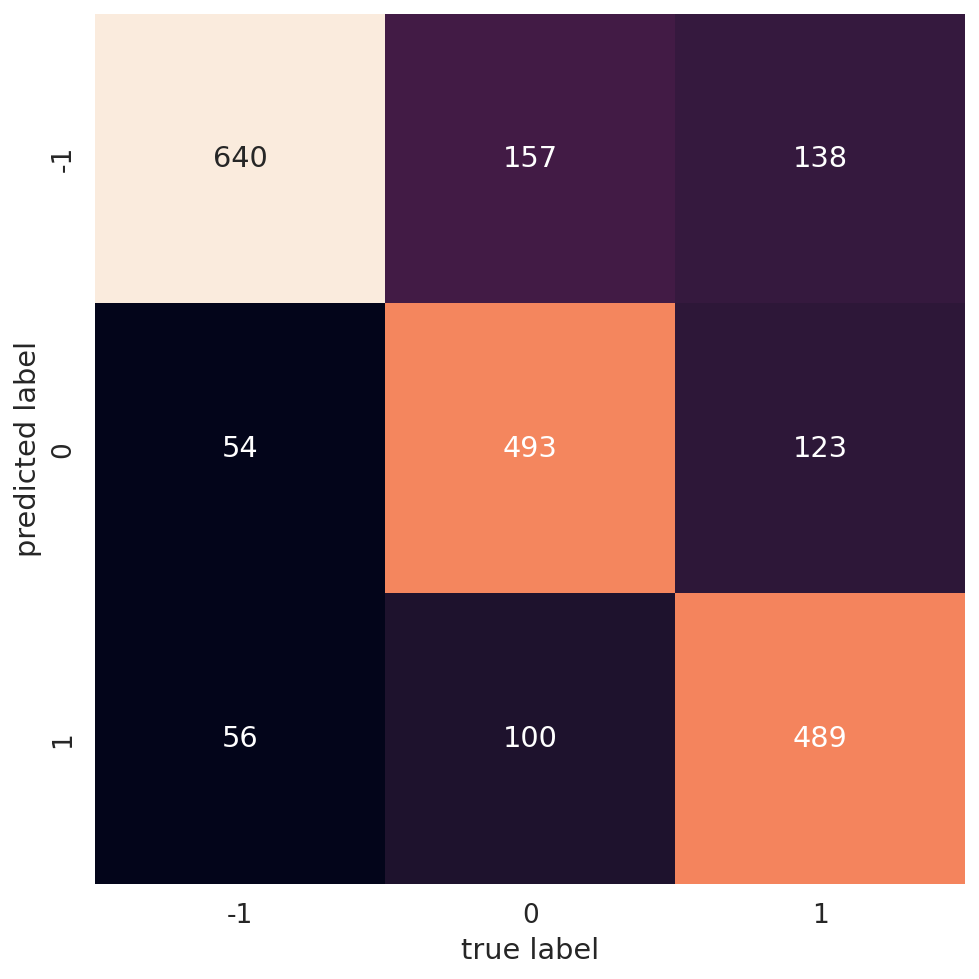

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(df_test.label, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(df_test.label, labels)

0.7208888888888889

In [ ]:
y_true = df_test.label
y_pred = labels
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred,average='macro')
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred,average='macro')
print(precision,recall)

0.7261508030052449 0.720888888888889


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
pr = precision_recall_fscore_support(y_true, y_pred,average='macro')
print(pr)

(0.7261508030052449, 0.720888888888889, 0.7183617943047498, None)


# LinearSvm - ML



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), LinearSVC())

model.fit(df_train.tuned_tweet, df_train.label)
labels = model.predict(df_test.tuned_tweet)

Text(198.86, 0.5, 'predicted label')

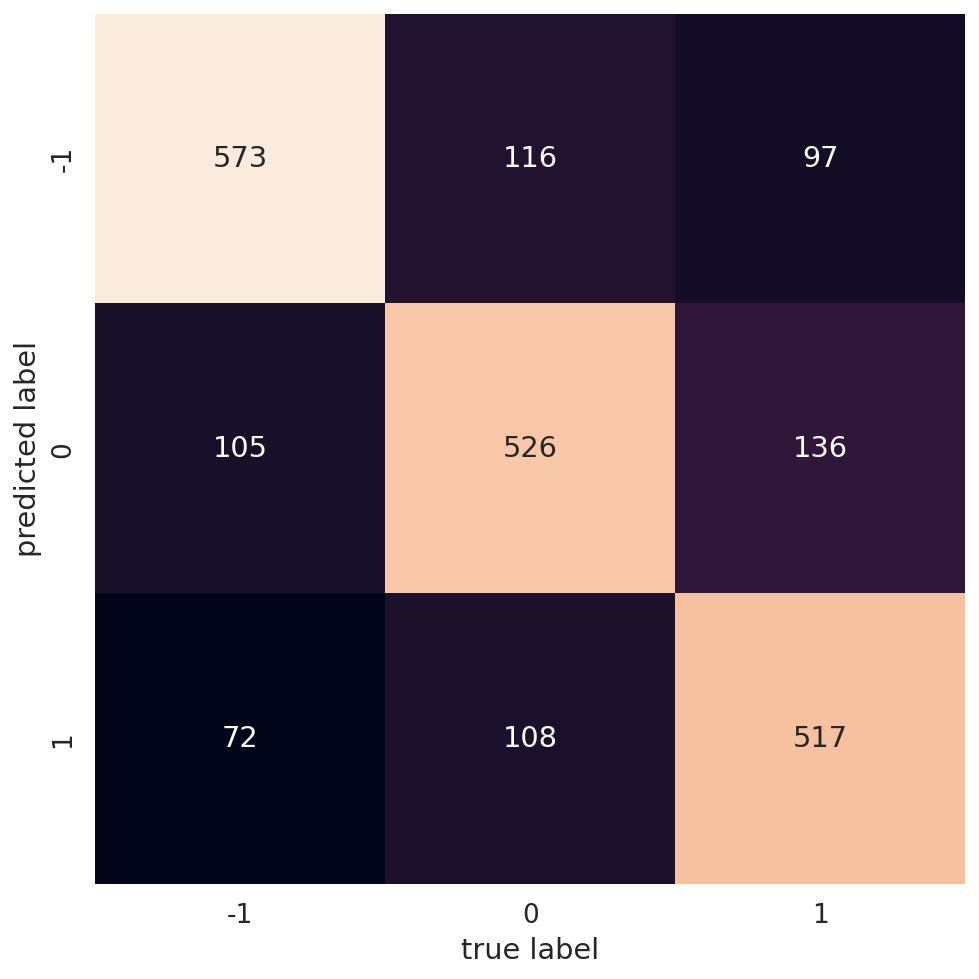

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(df_test.label, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(df_test.label, labels)

0.7182222222222222

In [ ]:
y_true = df_test.label
y_pred = labels
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred,average='macro')
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred,average='macro')
print(precision,recall)

0.7188489265838488 0.7182222222222222


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
pr = precision_recall_fscore_support(y_true, y_pred,average='macro')
print(pr)

(0.7188489265838488, 0.7182222222222222, 0.7180498684465181, None)


# RBFSvm - ML



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), SVC(kernel='rbf', random_state=1, gamma=0.1, C=5))

model.fit(df_train.tuned_tweet, df_train.label)
labels = model.predict(df_test.tuned_tweet)

Text(198.86, 0.5, 'predicted label')

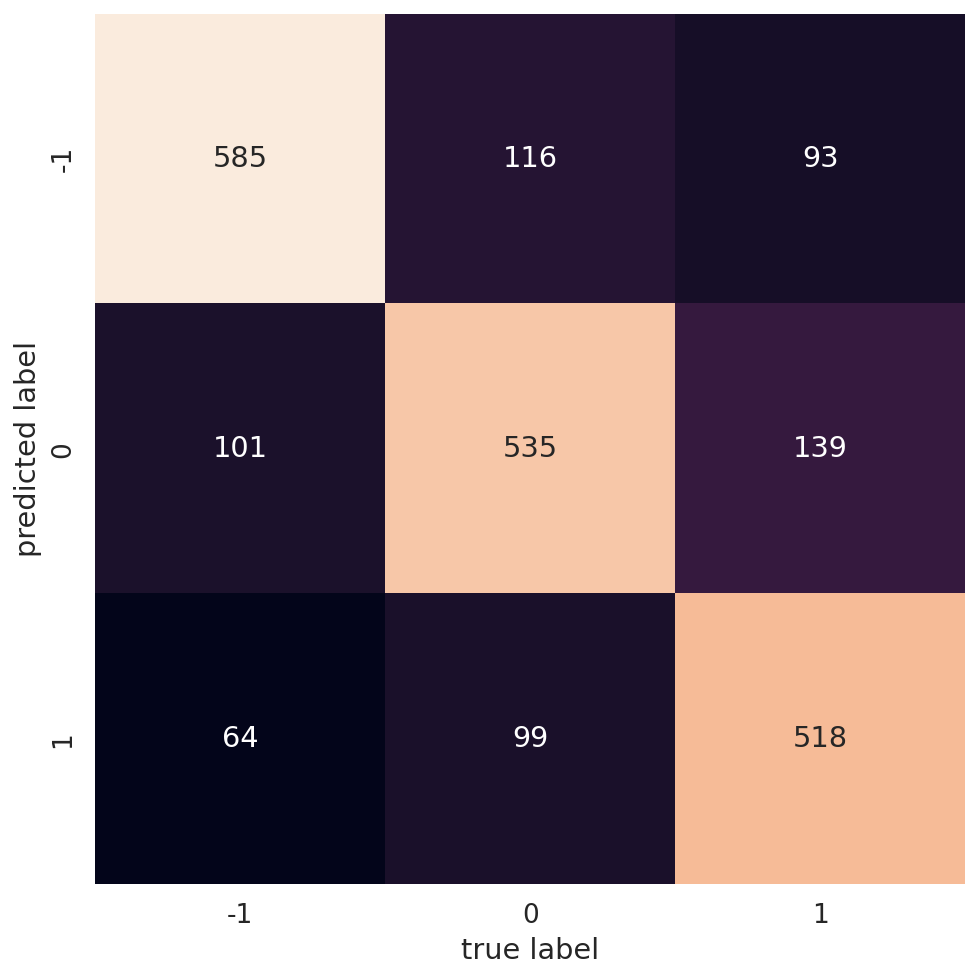

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(df_test.label, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(df_test.label, labels)

0.728

In [ ]:
y_true = df_test.label
y_pred = labels
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred,average='macro')
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred,average='macro')
print(precision,recall)

0.7292481693162299 0.7280000000000001


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
pr = precision_recall_fscore_support(y_true, y_pred,average='macro')
print(pr)

(0.7292481693162299, 0.7280000000000001, 0.7277935390862743, None)


# Random Forest -ML

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), RandomForestClassifier(max_depth=3, random_state=42))


model.fit(df_train.tuned_tweet, df_train.label)
labels = model.predict(df_test.tuned_tweet)

Text(198.86, 0.5, 'predicted label')

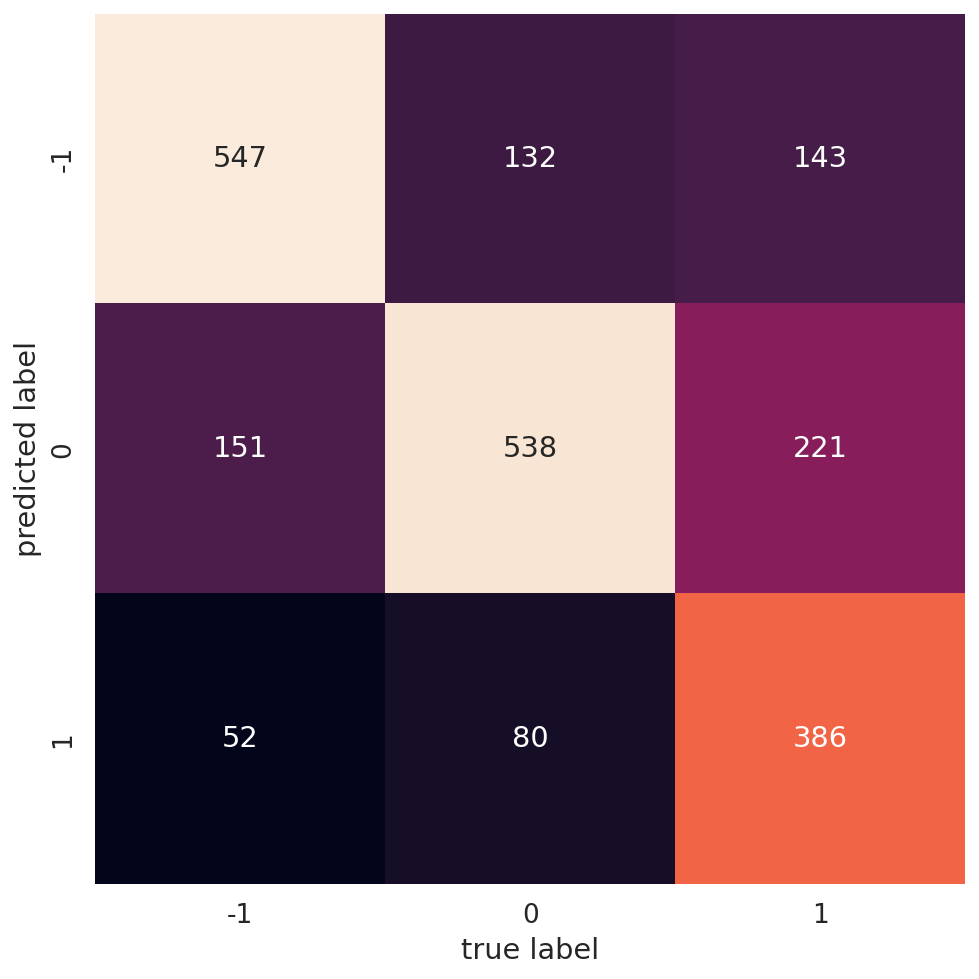

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(df_test.label, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(df_test.label, labels)

0.6537777777777778

In [ ]:
y_true = df_test.label
y_pred = labels
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred,average='macro')
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred,average='macro')
print(precision,recall)

0.6672775526790126 0.6537777777777779


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
pr = precision_recall_fscore_support(y_true, y_pred,average='macro')
print(pr)

(0.6672775526790126, 0.6537777777777779, 0.6509847772786589, None)
